# Just operation policies of Guadalajara’s Aquapheric under drought conditions

## Formulation 1 plan. No uncertainties except flows
1. Define ranges of the flow under drought based on the average 2020 flow. Currently set to 0 and 150% of the average flow for all sources. L
2. Define the supplied demand ratio of each supply area + a justice as objectives (min for now)
3. Aquapheric flows as levers currently. Later Original RBFs (inputs: water flows5, outputs: AqP flows4) (not implemented)
5. Conduct an optimization (n policies, x scenarios (water flows)) This will produce a dataframe with n policies that generate n sets of objectives for each scenario.
7. Calculate an indicator of performance for each policy and each objective across all the scenarios. (average for now)
8. Visualize

### Unresolved issues
* How to visualize other outcomes when using Optimize Evaluator


In [1]:


from ema_workbench import (Model, RealParameter, ScalarOutcome,
                           MultiprocessingEvaluator, ema_logging,
                           Constant, Scenario, Constraint,optimize)


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import numpy as np

In [2]:
from AMG_function import AMG_model_function


outcomes = AMG_model_function(chapala_flow= 7.1, calderon_flow= 0, zapotillo_flow= 0, pozos_flow= 2.2, toluquilla_flow= 0.4, 
                aqp1_PP2_to_PP3=0.2, aqp2_PP3_to_Pozos=-0.7, aqp3_Pozos_to_Toluquilla=-0.6, aqp4_Toluquilla_to_PP1=-0.6)



print(outcomes)

pd.DataFrame(outcomes, index=[0]).to_csv("tests/validation.csv")


{'delivered_PP1': 5.751, 'delivered_PP2': 1.349, 'delivered_PP3': 0, 'delivered_Toluquilla': 0.4, 'delivered_Pozos': 2.2, 'supplied_PP1': 2.6693019600000003, 'supplied_PP2': 0.6854705, 'supplied_PP3': 0.8709999999999999, 'supplied_Toluquilla': 0.68757754, 'supplied_Pozos': 1.0504, 'total_supplied': 5.96375, 'demand_PP1': 2.93292, 'demand_PP2': 0.75717, 'demand_PP3': 0.94351, 'demand_Toluquilla': 0.78229, 'demand_Pozos': 1.20143, 'supplied_demand_PP1': 0.91012, 'supplied_demand_PP2': 0.90531, 'supplied_demand_PP3': 0.92315, 'supplied_demand_Toluquilla': 0.87893, 'supplied_demand_Pozos': 0.87429, 'supplied_demand_deficit_PP1': 0.08987999999999996, 'supplied_demand_deficit_PP2': 0.09469000000000005, 'supplied_demand_deficit_PP3': 0.07684999999999997, 'supplied_demand_deficit_Toluquilla': 0.12107000000000001, 'supplied_demand_deficit_Pozos': 0.12571, 'supply_percapita_PP1': 146.0, 'supply_percapita_PP2': 133.0, 'supply_percapita_PP3': 144.0, 'supply_percapita_Toluquilla': 130.0, 'supply_pe

# 1. Tests for a single drought scenario and no uncertainty

## 1.1 Formulation 1 with only disagregated supplied demand outcomes

In [3]:
experiments=["gini and supplied demand deficit minimization - 5k nfe.csv",
             "gini minimization and supply per capita maximization - 5k nfe.csv",
             "gini minimization and supplied demand maximization - 5k nfe.csv",
             "only GINI supplied demand optimization.csv"]

In [4]:
from AMG_function import AMG_model_function

#performance_indicators = ["supplied_demand", "supply_percapita", "supplied_demand_deficit", "supply_deficit"]
#justice_indicators = ["supply_percapita_GINI", "supplied_demand_GINI", "ZAs_below_128", "ZAs_below_100", "ZAs_below_50"]

#SETTINGS
performance_indicator_to_maximize = ""
performance_indicator_to_minimize = "supplied_demand_deficit"
info_indicator = "supplied"
justice_indicators_to_minimize = ['supplied_demand_GINI', "ZAs_below_50"]
utilitarian_indicators_to_maximize = "average_supply_percapita"
scenario = "non-solvable-h-drought"
pozos_to_toluquilla = 0 #set the max value of the segment of the aquapheric between pozos and toluquilla as the current physical restriction
n_nfe= 10000
epsilon = 0.1
seed = 1234

experiment_name = f"{scenario} - {justice_indicators_to_minimize[0]} {justice_indicators_to_minimize[1]} {performance_indicator_to_minimize} {performance_indicator_to_maximize} {utilitarian_indicators_to_maximize} - {n_nfe}nfe eps{epsilon} - restr{pozos_to_toluquilla}"
experiment_nickname = "asdasd"
#ema_logging.log_to_stderr(ema_logging.INFO)

ZA_names = ["PP1", "PP2", "PP3", "Toluquilla", "Pozos"]

#instantiate the model
AMG_model = Model("AMGmodel", function = AMG_model_function)

#LEVERS
AMG_model.levers = [RealParameter('aqp1_PP2_to_PP3',-1,1),
                    RealParameter('aqp2_PP3_to_Pozos',-1,1),
                    RealParameter('aqp3_Pozos_to_Toluquilla',-1,pozos_to_toluquilla),
                    RealParameter('aqp4_Toluquilla_to_PP1',-1,1)] #Restriction of flow between posoz and toluquilla applied

#OUTCOMES
if performance_indicator_to_maximize == "":
    maximizing_outcomes = []
else: maximizing_outcomes = [f"{performance_indicator_to_maximize}_{ZA}" for ZA in ZA_names]
    
if performance_indicator_to_minimize == "":
    minimizing_outcomes = []
else: minimizing_outcomes = [f"{performance_indicator_to_minimize}_{ZA}" for ZA in ZA_names]

if info_indicator == "":
    info_outcomes = []
else: info_outcomes = [f"{info_indicator}_{ZA}" for ZA in ZA_names]


AMG_model.outcomes = [ScalarOutcome(scalar_outcome, kind=ScalarOutcome.MAXIMIZE) for scalar_outcome in maximizing_outcomes] + [
    ScalarOutcome(minimizing_outcome, kind=ScalarOutcome.MINIMIZE) for minimizing_outcome in minimizing_outcomes] + [
    ScalarOutcome(info_outcome, kind=ScalarOutcome.INFO) for info_outcome in info_outcomes] + [
    ScalarOutcome(utilitarian_indicators_to_maximize, kind=ScalarOutcome.MAXIMIZE)] + [
    ScalarOutcome(justice_outcome, kind=ScalarOutcome.MINIMIZE) for justice_outcome in justice_indicators_to_minimize]

In [5]:
#Scenario setting
drougth_multiplier = 0.5
scenario1 = {"name":"test",'chapala_flow' : 6.9*drougth_multiplier, 'calderon_flow' : 1*drougth_multiplier, 'zapotillo_flow' : 1*drougth_multiplier, 'pozos_flow' : 2.3*drougth_multiplier, 'toluquilla_flow' : 0.5*drougth_multiplier}
scenario_2020 = {"name":"2020_drought",'chapala_flow' : 7.1, 'calderon_flow' : 0, 'zapotillo_flow' : 0, 'pozos_flow' : 2.2, 'toluquilla_flow' : 0.4}
scenario_sufficientarian_test = {"name":"sufficientarian_test",'chapala_flow' : 0.88, 'calderon_flow' : 1, 'zapotillo_flow' : 0.59, 'pozos_flow' : 2, 'toluquilla_flow' : 0.95}

scenarios = [scenario1, scenario_2020, scenario_sufficientarian_test]

In [6]:
from ema_workbench import MultiprocessingEvaluator, ema_logging
from ema_workbench.em_framework.optimization import ArchiveLogger, EpsilonProgress
from ema_workbench.em_framework.outcomes import Constraint
import numpy as np
import random

# we need to store our results for each seed
results = []
convergences = []

# Using supplied demand and a non negative constraint
ema_logging.log_to_stderr(ema_logging.INFO)

# Define scenario from list
scenario = Scenario(**scenarios[0])

n_outcomes = len(AMG_model.outcomes) - len(info_outcomes)

# CONSTRAIN
non_negative_outcomes = [f"supplied_{ZA}" for ZA in ZA_names]  # list of restricted outcomes

# Lambda function for non negative
constraints = [Constraint("non_negative_constraint", outcome_names=[outcome],
                         function=lambda x: max(0, -x)) for outcome in non_negative_outcomes]

# REPLICABLE OUTCOMES


# CONSTRAINED REPLICABLE OPTIMIZATION FOR 1 SCENARIO
with MultiprocessingEvaluator(AMG_model) as evaluator:
        
        for i in range(3):
        # we create 2 covergence tracker metrics
        # the archive logger writes the archive to disk for every x nfe
        # the epsilon progress tracks during runtime
            convergence_metrics = [
                ArchiveLogger(
                    "./archives",
                    [l.name for l in AMG_model.levers],
                    [o.name for o in AMG_model.outcomes],
                    base_filename=f"{i}.tar.gz",
                ),
                EpsilonProgress(),
            ]

            np.random.seed(i)
            random.seed(i)

            result, convergence = evaluator.optimize(
                nfe=n_nfe, searchover="levers", epsilons=[epsilon] * n_outcomes,  reference=scenario, convergence=convergence_metrics, constraints=constraints,
                
            ) #constraints=constraints,

        results.append(result)
        convergences.append(convergence)        




[MainProcess/INFO] pool started with 8 workers
11068it [01:58, 93.68it/s]                                                     
[MainProcess/INFO] optimization completed, found 431 solutions
11027it [01:48, 101.25it/s]                                                    
[MainProcess/INFO] optimization completed, found 432 solutions
11095it [01:27, 126.44it/s]                                                    
[MainProcess/INFO] optimization completed, found 451 solutions
[MainProcess/INFO] terminating pool


In [40]:
reference_set = epsilon_nondominated(results,  epsilons=[epsilon] * n_outcomes, problem=problem)
reference_set

,aqp1_PP2_to_PP3,aqp2_PP3_to_Pozos,aqp3_Pozos_to_Toluquilla,aqp4_Toluquilla_to_PP1,supplied_demand_deficit_PP1,supplied_demand_deficit_PP2,supplied_demand_deficit_PP3,supplied_demand_deficit_Toluquilla,supplied_demand_deficit_Pozos,average_supply_percapita,supplied_demand_GINI,ZAs_below_50
0,-0.163967,0.050129,-0.818775,-0.812426,0.67320,0.33591,0.34835,0.53385,0.04461,83.0,0.189958,0
1,-0.527753,-0.952284,-0.712341,-0.725569,0.65395,0.02362,0.09161,0.51759,0.64452,83.0,0.259787,0
2,-0.345214,-0.466109,-0.497099,-0.944944,0.70257,0.18032,0.11757,0.15647,0.49794,83.0,0.180737,1
3,-0.132532,0.022006,-0.410853,-0.637061,0.63433,0.36290,0.30732,0.34062,0.28052,83.0,0.099300,0
4,0.077286,0.021481,-0.418796,-0.875101,0.68709,0.54302,0.16241,0.14944,0.27650,83.0,0.183045,0
...,...,...,...,...,...,...,...,...,...,...,...,...
446,-0.451747,-0.530921,-0.934896,-0.855136,0.68266,0.08886,0.14631,0.59485,0.29614,83.0,0.205083,0
447,0.139948,0.126867,-0.311074,0.010241,0.49088,0.59681,0.19184,0.79556,0.27777,83.0,0.230661,1
448,-0.378099,-0.525695,-0.713998,-0.437808,0.59017,0.15209,0.09917,0.75806,0.41283,83.0,0.235080,1
449,-0.485904,-0.496396,-0.644957,-0.418694,0.58594,0.05954,0.19363,0.71658,0.43433,83.0,0.226764,1


In [39]:
from ema_workbench import (
    HypervolumeMetric
)

from ema_workbench.em_framework.optimization import to_problem
from ema_workbench.em_framework.optimization import epsilon_nondominated

def calculate_metrics(archives, reference_set):
    problem = to_problem(AMG_model, searchover="levers")

    hv = HypervolumeMetric(reference_set, problem)

    metrics = []
    for nfe, archive in archives.items():
        scores = {
            "hypervolume": hv.calculate(archive),
            "nfe": int(nfe),
        }
        metrics.append(scores)
    metrics = pd.DataFrame.from_dict(metrics)

    # sort metrics by number of function evaluations
    metrics.sort_values(by="nfe", inplace=True)
    return metrics


def plot_metrics(metrics, convergence):
    sns.set_style("white")
    fig, axes = plt.subplots(nrows=6, figsize=(8, 12), sharex=True)

    ax1, ax6 = axes

    ax1.plot(metrics.nfe, metrics.hypervolume)
    ax1.set_ylabel("hypervolume")


    ax6.set_xlabel("nfe")

    sns.despine(fig)

all_archives = []

for i in range(5):
    archives = ArchiveLogger.load_archives(f"./archives/{i}.tar.gz")
    all_archives.append(archives)

problem = to_problem(AMG_model, searchover="levers")
reference_set = epsilon_nondominated(results,  epsilons=[epsilon] * n_outcomes, problem=problem)[minimizing_outcomes]

metrics_by_seed = []
for entry in all_archives:
    metrics = calculate_metrics(entry, reference_set)
    metrics_by_seed.append(metrics)

sns.set_style("white")
fig, axes = plt.subplots(nrows=6, figsize=(8, 12), sharex=True)

ax1= axes

for metrics, convergence in zip(metrics_by_seed, convergences):
    ax1.plot(metrics.nfe, metrics.hypervolume)
    ax1.set_ylabel("hypervolume")


ax6.set_xlabel("nfe")


sns.despine(fig)

plt.show()

EMAError: The number of columns in the archive (5) does not match the expected number of decision variables and objectives (12).

In [24]:
from ema_workbench.em_framework.optimization import epsilon_nondominated


problem = to_problem(AMG_model, searchover="levers")
reference_set = epsilon_nondominated(results,  epsilons=[epsilon] * n_outcomes, problem=problem)

In [25]:
metrics_by_seed = []
for entry in all_archives:
    metrics = calculate_metrics(entry, reference_set)
    metrics_by_seed.append(metrics)

PlatypusError: objective with empty range

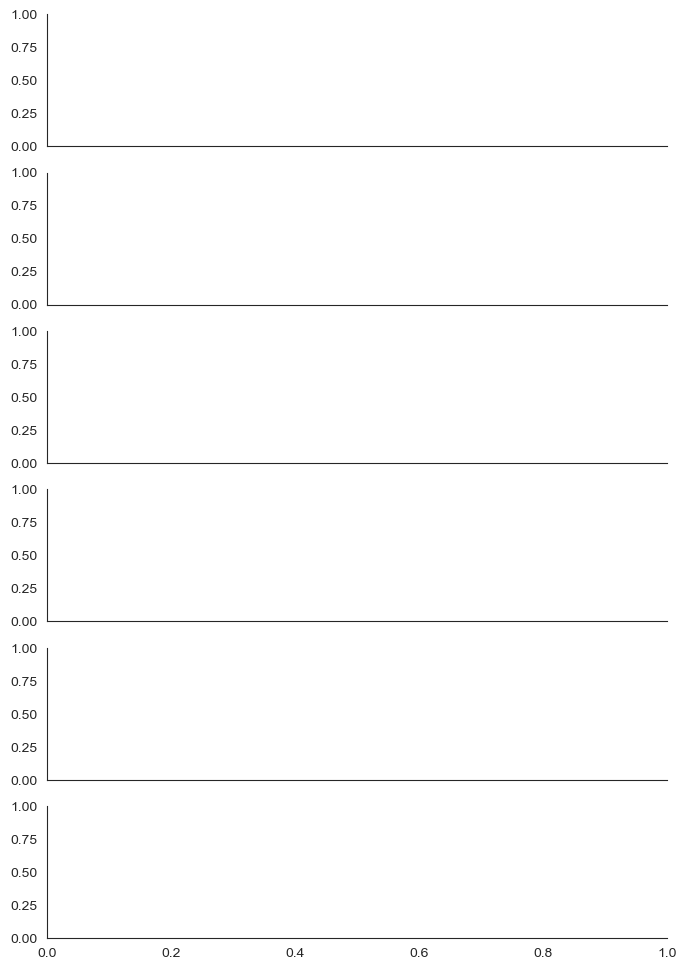

In [21]:
sns.set_style("white")
fig, axes = plt.subplots(nrows=6, figsize=(8, 12), sharex=True)

ax1= axes

for metrics, convergence in zip(metrics_by_seed, convergences):
    ax1.plot(metrics.nfe, metrics.hypervolume)
    ax1.set_ylabel("hypervolume")


ax6.set_xlabel("nfe")


sns.despine(fig)

plt.show()

In [ ]:
model = AMG_model

from ema_workbench import (
    HypervolumeMetric,
    GenerationalDistanceMetric,
    EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric,
    SpacingMetric,
)
from ema_workbench.em_framework.optimization import to_problem, epsilon_nondominated

problem = to_problem(model, searchover="levers")

reference_set = epsilon_nondominated(results, [0.5] * len(model.outcomes), problem)

hv = HypervolumeMetric(reference_set, problem)
gd = GenerationalDistanceMetric(reference_set, problem, d=1)
ei = EpsilonIndicatorMetric(reference_set, problem)
ig = InvertedGenerationalDistanceMetric(reference_set, problem, d=1)
sm = SpacingMetric(problem)


metrics_by_seed = []
for archives in all_archives:
    metrics = []
    for nfe, archive in archives.items():
        scores = {
            "generational_distance": gd.calculate(archive),
            "hypervolume": hv.calculate(archive),
            "epsilon_indicator": ei.calculate(archive),
            "inverted_gd": ig.calculate(archive),
            "spacing": sm.calculate(archive),
            "nfe": int(nfe),
        }
        metrics.append(scores)
    metrics = pd.DataFrame.from_dict(metrics)

    # sort metrics by number of function evaluations
    metrics.sort_values(by="nfe", inplace=True)
    metrics_by_seed.append(metrics)

PlatypusError: objective with empty range

AttributeError: 'DataFrame' object has no attribute 'hypervolume'

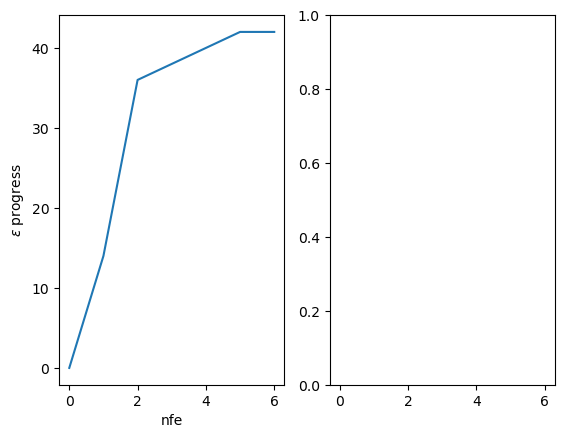

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True)
ax1.plot(convergence.epsilon_progress)
ax1.set_xlabel('nfe')
ax1.set_ylabel('$\epsilon$ progress')
ax2.plot(convergence.hypervolume)
ax2.set_ylabel('hypervolume')
sns.despine()
plt.show()

In [ ]:
import inspect
print(inspect.getsource(optimize))

def optimize(
    models,
    algorithm=EpsNSGAII,
    nfe=10000,
    searchover="levers",
    evaluator=None,
    reference=None,
    convergence=None,
    constraints=None,
    convergence_freq=1000,
    logging_freq=5,
    variator=None,
    **kwargs,
):
    """optimize the model

    Parameters
    ----------
    models : 1 or more Model instances
    algorithm : a valid Platypus optimization algorithm
    nfe : int
    searchover : {'uncertainties', 'levers'}
    evaluator : evaluator instance
    reference : Policy or Scenario instance, optional
                overwrite the default scenario in case of searching over
                levers, or default policy in case of searching over
                uncertainties
    convergence : function or collection of functions, optional
    constraints : list, optional
    convergence_freq :  int
                        nfe between convergence check
    logging_freq : int
                   number of generations between logging of progress


In [ ]:
from data_functions import full_dataframe
full_df = full_dataframe(results,experiment_name=experiment_name, scenario=scenario)
full_df.to_csv(f"experiment_results/single_scenario_optimizations/{experiment_name}.csv")


In [ ]:
dataframe=full_df[[f"supply_percapita_{ZA}" for ZA in ZA_names]+["supplied_demand_GINI"]]

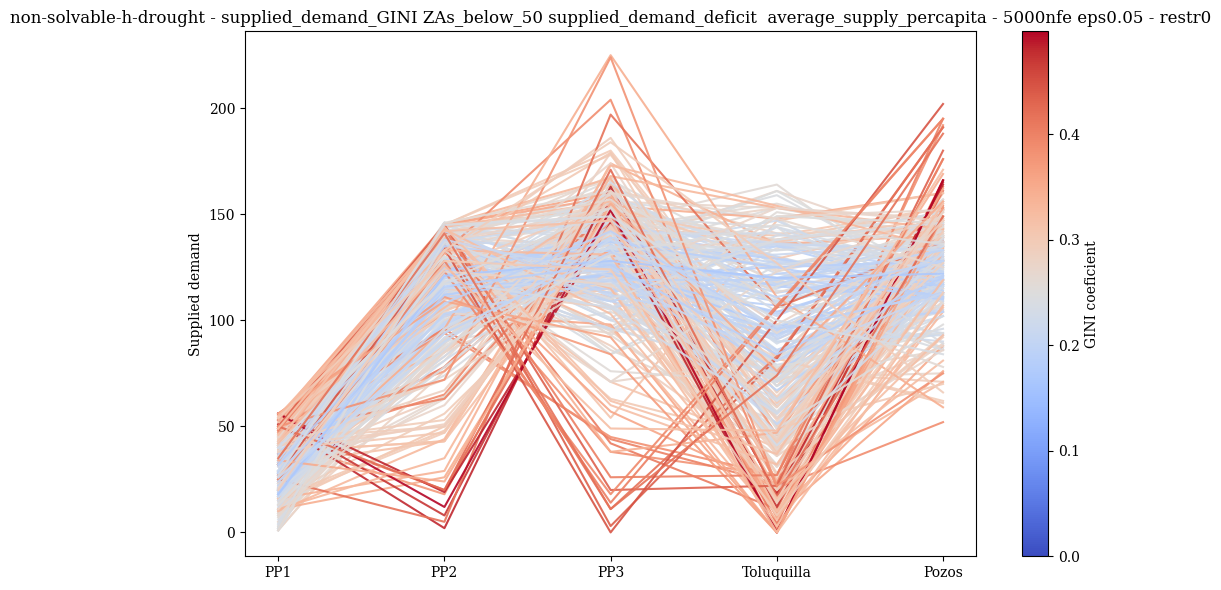

In [ ]:
from viz_functions import plot_parallel_axis

dataframe

plot_parallel_axis(dataframe, experiment_name, "Supplied demand", "supplied_demand_GINI","GINI coeficient")

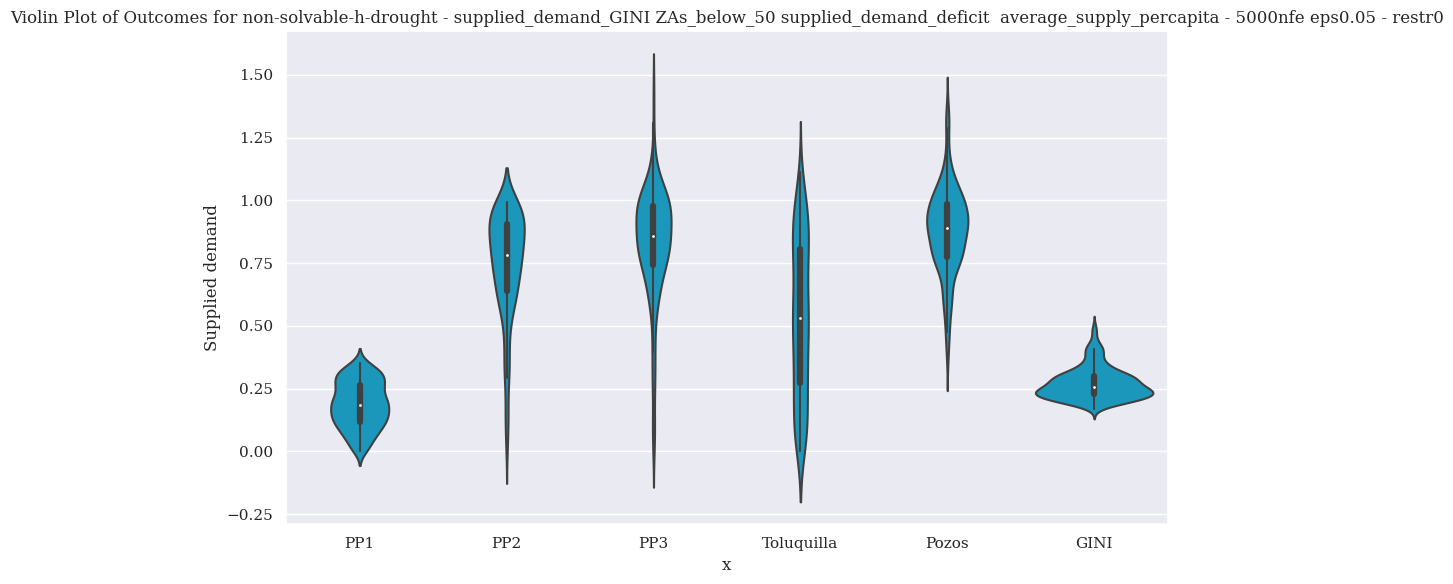

In [ ]:
from viz_functions import violin_plot

results_plot = full_df[[f"supplied_demand_{ZA}" for ZA in ZA_names]+["supplied_demand_GINI"]]
violin_plot(results_plot,experiment_name, y_axis="Supplied demand")

from viz_functions import parallel_axis_plot

parallel_axis_plot(results_plot)

In [ ]:
experiment_results = full_df


experiment_results.head()

,aqp4_Toluquilla_to_PP1,aqp1_PP2_to_PP3,aqp2_PP3_to_Pozos,aqp3_Pozos_to_Toluquilla,delivered_PP1,delivered_PP2,delivered_PP3,delivered_Toluquilla,delivered_Pozos,supplied_PP1,...,supply_percapita_average,min_supplied_demand,supply_percapita_GINI,supplied_demand_GINI,average_supply_percapita,ZAs_below_128,ZAs_below_100,ZAs_below_50,scenario,experiment
0,-0.316584,-0.917874,-0.227633,-0.650408,0.7128,0.1672,1.59,0.95,2.0,0.173401,...,102.2,0.05912,0.273190,0.279174,78.0,2.0,2.0,1.0,,non-solvable-h-drought - supplied_demand_GINI ...
1,-0.085165,-0.587864,0.037729,-0.070327,0.7128,0.1672,1.59,0.95,2.0,0.323824,...,100.8,0.11041,0.215873,0.215381,78.0,3.0,2.0,1.0,,non-solvable-h-drought - supplied_demand_GINI ...
2,0.353092,-0.745221,-0.001168,-0.059952,0.7128,0.1672,1.59,0.95,2.0,0.608691,...,93.8,0.20754,0.204691,0.208148,78.0,4.0,2.0,1.0,,non-solvable-h-drought - supplied_demand_GINI ...
3,0.102285,-0.587864,0.075773,-0.070327,0.7128,0.1672,1.59,0.95,2.0,0.445666,...,97.2,0.15195,0.213169,0.214939,78.0,3.0,2.0,1.0,,non-solvable-h-drought - supplied_demand_GINI ...
4,-0.567587,-0.565933,-0.134455,-0.320634,0.7128,0.1672,1.59,0.95,2.0,0.010249,...,107.8,0.00349,0.276067,0.271756,78.0,2.0,2.0,1.0,,non-solvable-h-drought - supplied_demand_GINI ...


In [ ]:
experiment_results = full_df.drop(full_df.index, inplace=False)
experiment_results.head()

,aqp4_Toluquilla_to_PP1,aqp1_PP2_to_PP3,aqp2_PP3_to_Pozos,aqp3_Pozos_to_Toluquilla,delivered_PP1,delivered_PP2,delivered_PP3,delivered_Toluquilla,delivered_Pozos,supplied_PP1,...,supply_percapita_average,min_supplied_demand,supply_percapita_GINI,supplied_demand_GINI,average_supply_percapita,ZAs_below_128,ZAs_below_100,ZAs_below_50,scenario,experiment


In [ ]:
experiments=["gini and supplied demand deficit minimization - 5k nfe.csv",
             "gini minimization and supply per capita maximization - 5k nfe.csv",
             "gini minimization and supplied demand maximization - 5k nfe.csv",
             "only GINI supplied demand optimization.csv"]

experiment_results = full_df.drop(full_df.index, inplace=False)

for experiment in experiments:
    df=pd.read_csv(f"experiment_results/single_scenario_optimizations/{experiment}")
    print(df.columns[-6:])
    experiment_results=pd.concat([experiment_results,df])#

compund_experiment_name = "baseline scenario different formulations 5000nfe"
experiment_results.to_csv(f"experiment_results/single_scenario_optimizations/{compund_experiment_name}.csv")
experiment_results.tail()

Index(['supply_percapita_Pozos', 'min_supplied_demand', 'min_deficit_sq',
       'supplied_demand_GINI', 'experiment', 'scenario'],
      dtype='object')
Index(['supply_percapita_Pozos', 'min_supplied_demand', 'min_deficit_sq',
       'supplied_demand_GINI', 'experiment', 'scenario'],
      dtype='object')
Index(['supply_percapita_Pozos', 'min_supplied_demand', 'min_deficit_sq',
       'supplied_demand_GINI', 'experiment', 'scenario'],
      dtype='object')
Index(['supply_percapita_Pozos', 'min_supplied_demand', 'min_deficit_sq',
       'supplied_demand_GINI', 'experiment', 'scenario'],
      dtype='object')


,aqp4_Toluquilla_to_PP1,aqp1_PP2_to_PP3,aqp2_PP3_to_Pozos,aqp3_Pozos_to_Toluquilla,delivered_PP1,delivered_PP2,delivered_PP3,delivered_Toluquilla,delivered_Pozos,supplied_PP1,...,supply_percapita_GINI,supplied_demand_GINI,average_supply_percapita,ZAs_below_128,ZAs_below_100,ZAs_below_50,scenario,experiment,Unnamed: 0,min_deficit_sq
1886,-0.989297,0.178666,-0.683449,0.901822,5.751,1.349,0.0,0.4,2.2,2.416259,...,NaN,0.376252,NaN,NaN,NaN,NaN,2020_drought,gini minimization and supplied demand maximiza...,1886.0,0.00334
1887,0.450793,0.591937,-0.778967,0.864791,5.751,1.349,0.0,0.4,2.2,3.352317,...,NaN,0.290997,NaN,NaN,NaN,NaN,2020_drought,gini minimization and supplied demand maximiza...,1887.0,0.03041
1888,-0.484399,0.803595,0.839958,0.757744,5.751,1.349,0.0,0.4,2.2,2.744443,...,NaN,0.343524,NaN,NaN,NaN,NaN,2020_drought,gini minimization and supplied demand maximiza...,1888.0,0.00106
1889,-0.417371,-0.023318,-0.819881,-0.605251,5.751,1.349,0.0,0.4,2.2,2.788011,...,NaN,0.079982,NaN,NaN,NaN,NaN,2020_drought,gini minimization and supplied demand maximiza...,1889.0,0.00540
0,-0.669592,0.195002,-0.684482,-0.635428,5.751,1.349,0.0,0.4,2.2,2.624067,...,NaN,0.003272,NaN,NaN,NaN,NaN,2020_drought,only GINI supplied demand optimization,0.0,0.00469


In [ ]:
dataframe= experiment_results[[f"supplied_demand_{ZA}" for ZA in ZA_names]+["supplied_demand_GINI"]+["experiment"]]
dataframe.tail(2)

,supplied_demand_PP1,supplied_demand_PP2,supplied_demand_PP3,supplied_demand_Toluquilla,supplied_demand_Pozos,supplied_demand_GINI,experiment
1889,0.95059,1.09702,0.85189,0.72282,0.81227,0.079982,gini minimization and supplied demand maximiza...
0,0.89469,0.90960,0.90902,0.90732,0.90185,0.003272,only GINI supplied demand optimization


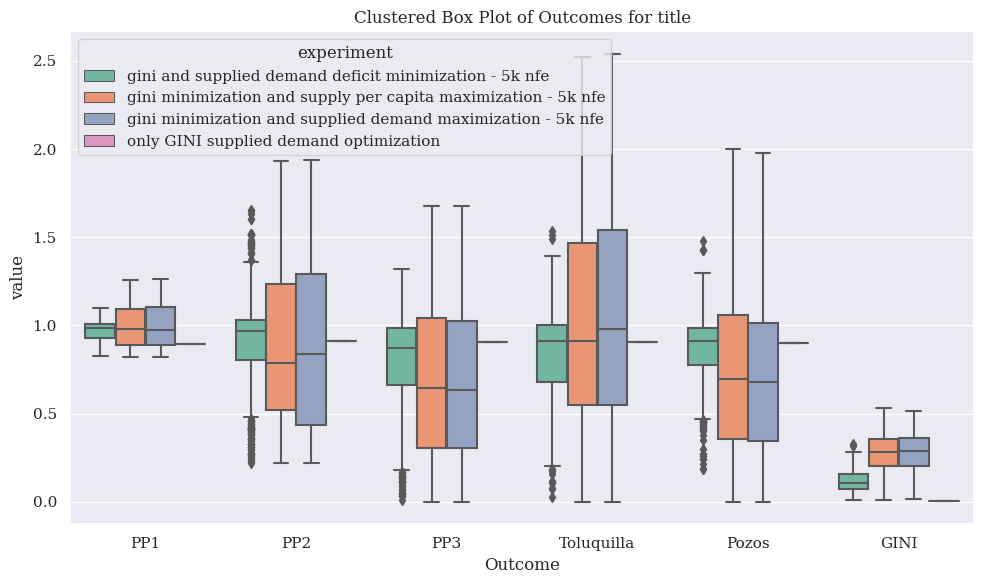

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select columns for the DataFrame
dataframe = experiment_results[[f"supplied_demand_{ZA}" for ZA in ZA_names] + ["supplied_demand_GINI", "experiment"]]

# Create a DataFrame with the necessary columns
viz_data = dataframe.rename(columns=lambda x: x.split('_')[-1])

# Melt the DataFrame to long format for plotting
viz_data_melted = viz_data.melt(id_vars=['experiment'], var_name='Outcome')

# Create the clustered box plot with customized parameters
plt.figure(figsize=(10, 6))
sns.boxplot(x='Outcome', y='value', hue='experiment', data=viz_data_melted, palette='Set2')
plt.title('Clustered Box Plot of Outcomes for {}'.format("title"))
plt.tight_layout()

# Show the plot
plt.savefig("experiment_results/experiments_boxplot.png")
plt.show()

